## Prerequisuites

> Upload this notebook onto *Sagemaker Notebook Instance*

로컬호스트에서 실행하고 있다면,
[**AWS Console**](https://console.aws.amazon.com/iam) 에서 적절한 롤을 만들고 *role_name* 을 수정한다.

해당 롤은 *AmazonSageMakerFullAccess* 권한만 있으면 된다.

## Step 0: Configuration

In [8]:
%load_ext autoreload
%autoreload 1

# Built-Ins:
import os
from matplotlib import pyplot as plt
from base64 import b64decode, b64encode

# External Dependencies:
import boto3
import sagemaker
import mxnet as mx
from sagemaker.mxnet.model import MXNetModel
from gluoncv.utils import download, viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
BUCKET_NAME = sagemaker.Session().default_bucket()
print(BUCKET_NAME)

sagemaker-ap-northeast-2-929831892372


In [3]:
session = boto3.session.Session()
s3 = session.resource('s3')
bucket = s3.Bucket(BUCKET_NAME)

In [4]:
role_name = 'AmazonSageMaker-ExecutionRole-20200129T183159'
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName=role_name)['Role']['Arn']

Couldn't call 'get_role' to get Role ARN from role name dongkyl to get Role path.


## Step 1: Deploy Model

In [5]:
# upload emtpy model.tar.gz
bucket.upload_file('model.tar.gz', Key='ssd_test/model.tar.gz')

In [9]:
mxnet_model = MXNetModel(
    name='mxnet-ssd-model',
    model_data=f's3://{BUCKET_NAME}/ssd_test/model.tar.gz',
    role=role,
    entry_point='inference.py',
    source_dir='src',
    framework_version='1.4.1',
    py_version='py3',
)

In [10]:
predictor = mxnet_model.deploy(
    instance_type='ml.c5.xlarge',
    initial_instance_count=1,
    accelerator_type='ml.eia2.large',
)

-----------!

## Step 2: Predict

check if model detect persons on not trained images well

In [11]:
s = None
bimage = None
download('https://sportshub.cbsistatic.com/i/r/2019/11/15/10869f78-1378-4aa5-b36b-085607ae3387/thumbnail/770x433/f3276ac966a56b7cb45987869098cddb/lionel-messi-argentina-brazil.jpg', path='messi.jpg')
with open('messi.jpg', 'rb') as fp:
    bimage = fp.read()
s = b64encode(bimage).decode('utf8')

In [21]:
%%time

res = None
res = predictor.predict({
    'short': 224,
    'image': s
})

CPU times: user 5.11 ms, sys: 1.47 ms, total: 6.59 ms
Wall time: 84.1 ms


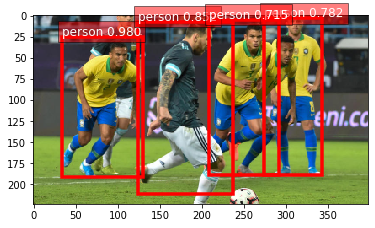

In [23]:
ax = viz.plot_bbox(mx.image.imresize(mx.image.imdecode(bimage), res['shape'][3], res['shape'][2]), mx.nd.array(res['bbox']), mx.nd.array(res['score']), mx.nd.array(res['cid']), class_names=['person'])
plt.show()

## Step 3: Cleanup Resources

In [22]:
mxnet_model.delete_model()
predictor.delete_endpoint()